# 오토인코더로 이미지의 특징을 추출하기

In [1]:
"""
신경망은 Universal function approximator로서 근사치를 출력
loss로는 입력 x를 얼마나 복원했는지를 뜻하는 복원 오차(정보손실값, reconstruction loss)를 사용한다.
저차원으로 압축된 표현을 latent variable(잠재 변수, z)라고 한다.
이때 일어나는 것은 '의미의 압축'. (기존 압축 알고리즘과 다름. 단순한 압축은 기존 방식이 훨씬 빠르고 안전함.)
비정상 거래 검출, 데이터 시각화, 복원, 의미 추출, 이미지 검색 등에 쓰임.
기계 번역, 생성 모델에 응용됨.

"""

&quot;\n신경망은 Universal function approximator로서 근사치를 출력\nloss로는 입력 x를 얼마나 복원했는지를 뜻하는 복원 오차(정보손실값, reconstruction loss)를 사용한다.\n저차원으로 압축된 표현을 latent variable(잠재 변수, z)라고 한다.\n이때 일어나는 것은 &#39;의미의 압축&#39;. (기존 압축 알고리즘과 다름. 단순한 압축은 기존 방식이 훨씬 빠르고 안전함.)\n비정상 거래 검출, 데이터 시각화, 복원, 의미 추출, 이미지 검색 등에 쓰임.\n기계 번역, 생성 모델에 응용됨.\n\n&quot;

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3차원 플롯을 그리는 용도.
from matplotlib import cm #데이터 포인트에 색상을 입힘.
import numpy as np

In [3]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [4]:
# Fashion MNIST 데이터셋. 학습데이터만 사용한다.
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz
100%|█████████▉| 26329088/26421880 [00:48&lt;00:00, 653831.59it/s]Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw

0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz

  0%|          | 0/29515 [00:00&lt;?, ?it/s]
32768it [00:00, 33296.65it/s]                           

0it [00:00, ?it/s]Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw

 99%|█████████▉| 4382720/4422102 [00:06&lt;00:00, 900130.80it/s]

0it [00:00, ?it/s]Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


8192it [00:00, 16398.43it/s]            
Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.d

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다.(추가)
        )

    def forward(self, x):
        encoded = self.encoder(x) #잠재 변수
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss() #같은 크기의 행렬을 두개 받아 계산해주는 객체 생성(인스턴스화).
"""
파이토치의 optim 모듈은 일반적으로 사용하는 최적화 알고리즘들을 클래스의 형태롤 제공한다. 
SGD, RMSProp, Adam 등이 정의돼 있음.
"""

&#39;\n파이토치의 optim 모듈은 일반적으로 사용하는 최적화 알고리즘들을 클래스의 형태롤 제공한다. \nSGD, RMSProp, Adam 등이 정의돼 있음.\n&#39;

In [7]:
# 원본 이미지를 시각화 하기 (첫번째 열)
# 5개를 가져와 모델에 바로 넣을 수 있도록 전처리
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255. # 모델이 인식하는 0-1사이의 값으로 만들기. trainloader에선 안하는데, 자동으로 해주는건가?

In [8]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) # 입력이 y이다.
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad() #남아 있을 수 있는 기울기에 대한 정보를 초기화.
        loss.backward() #기울기를 구하기.
        optimizer.step() #최적화 진행.


26427392it [01:00, 653831.59it/s]                              [Epoch 1]


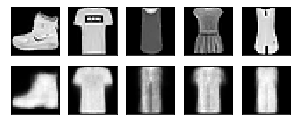


4423680it [00:20, 900130.80it/s]                             [Epoch 2]


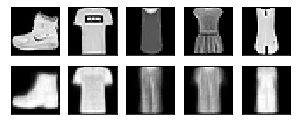

[Epoch 3]


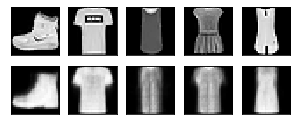

[Epoch 4]


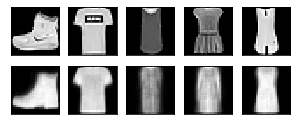

[Epoch 5]


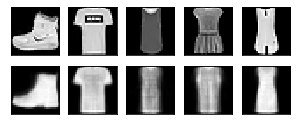

[Epoch 6]


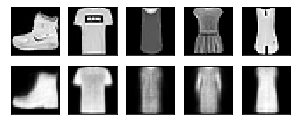

[Epoch 7]


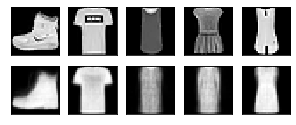

[Epoch 8]


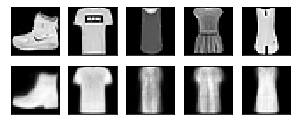

[Epoch 9]


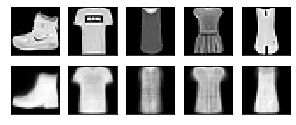

[Epoch 10]


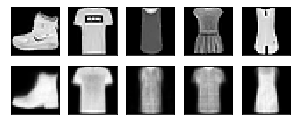

In [9]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) #cpu로 가져오기
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

# 잠재변수 들여다보기

In [10]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28) #200개 준비
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE) 
encoded_data, _ = autoencoder(test_x) #encode
encoded_data = encoded_data.to("cpu")

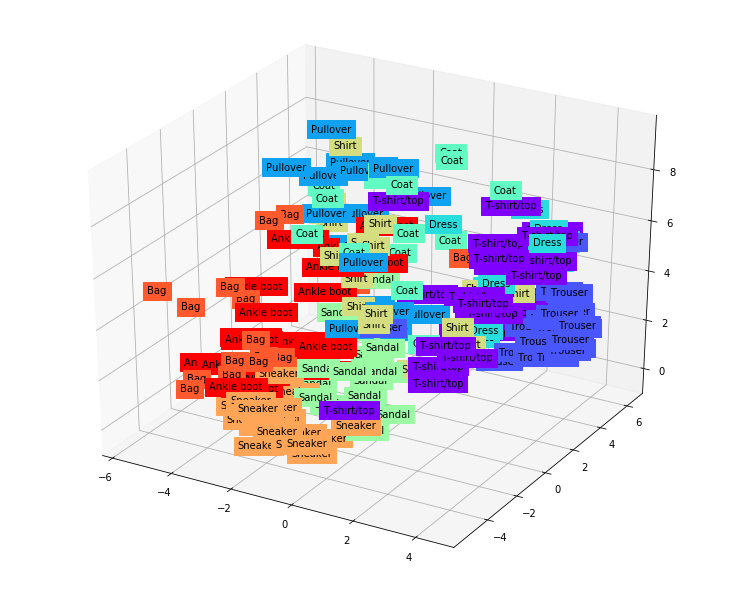

In [11]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

#넘파이 행렬로 변환
X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels): #같은 길이의 행렬을 묶어줌. ex)[1,2,3]과 [a,b,c] -> [1,a][2,b][3,c]
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9)) #색상지정
    ax.text(x, y, z, name, backgroundcolor=color)

#모든 데이터가 한눈에 들어오도록 액자 안의 x,y,z의 최댓값과 최솟값을 지정.
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

#같은 라벨의 이미지의 잠재변수는 서로 모인다. 그 외의 윗옷류, 신발류도 서로 가까이 자리한다.